In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision

from sklearn.decomposition import PCA

from src.utils import load_best_model, display_image
from src.models import OriginalPretextNetwork, OurPretextNetwork
from src.transforms import RelicAugmentationCreator, TINY_IMAGENET_TRANSFORM

from typing import List, Callable

In [3]:
def get_images(dir: str, n_images: int) -> List[str]:
    """ Return the first `n_images` images that are valid RGB images. """
    fns = os.listdir(dir)

    images = []
    i = 0
    while len(images) < n_images and i < len(fns):
        path = os.path.join(dir, fns[i])
        image = torchvision.io.read_image(path)
        if len(image.shape) == 3 and image.shape[0] == 3: # not grayscale and no alpha channel
            images.append(image / 255)
        i += 1

    return images


def get_embeddings(images: List[torch.Tensor], model: nn.Module) -> np.ndarray:
    """ Compute and return all embeddings using the given model. """
    model.eval()

    embeddings = []
    for img in images:
        x = TINY_IMAGENET_TRANSFORM(img)
        emb = model.get_embedding(img.unsqueeze(0))
        embeddings.append(emb.detach().numpy())
    
    return np.array(embeddings).squeeze()


## Setup
Load images from 2 different classes

Class 1:


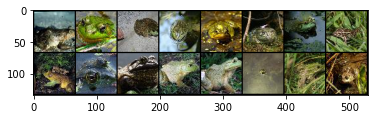

Class 2:


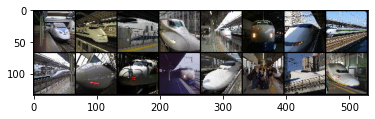

In [4]:
class1_dir = os.path.join("data", "tiny-imagenet-200", "train", "n01641577", "images") # some frogs
class2_dir = os.path.join("data", "tiny-imagenet-200", "train", "n02917067", "images") # highspeed trains

# get 50 images for each class
images1 = get_images(class1_dir, n_images=50)
images2 = get_images(class2_dir, n_images=50)

print("Class 1:")
display_image(images1[:16])
print("Class 2:")
display_image(images2[:16])

Apply 2 different styles all images in both classes. Make sure to generate 2 random functions that are very distinct from each other!

Class 1, style 1:


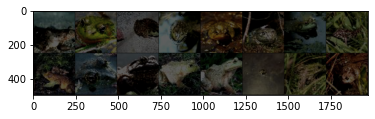

Class 1, style 2:


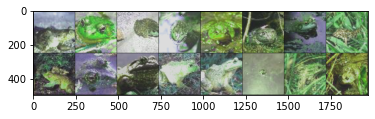

Class 2, style 1:


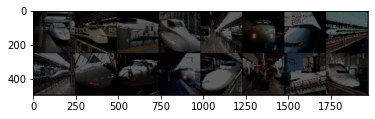

Class 2, style 2:


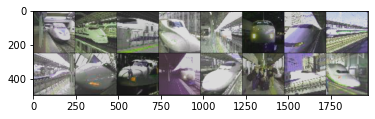

In [15]:
rac = RelicAugmentationCreator(
    min_crop_scale=1.0,
    solarize_prob=0.0,
    grayscale_prob=0.0,
)
style1 = rac.get_random_function()
style2 = rac.get_random_function()

images1_style1 = [style1(img) for img in images1]
images1_style2 = [style2(img) for img in images1]
images2_style1 = [style1(img) for img in images2]
images2_style2 = [style2(img) for img in images2]

print("Class 1, style 1:")
display_image(images1_style1[:16])
print("Class 1, style 2:")
display_image(images1_style2[:16])
print("Class 2, style 1:")
display_image(images2_style1[:16])
print("Class 2, style 2:")
display_image(images2_style2[:16])

## Original Model
Create embeddings of all images using the model from the original approach.

In [16]:
experiment_id = "original_pretext_resnet18"
original_model = load_best_model(experiment_id, OriginalPretextNetwork(backbone="resnet18"))

embeddings = get_embeddings(images1_style1 + images1_style2 + images2_style1 + images2_style2, original_model)
embeddings.shape

(200, 1000)

Apply PCA with 2 principal components to all embeddings.

In [17]:
pca = PCA(n_components=2)
emb_pca = pca.fit_transform(embeddings)
emb_pca.shape

(200, 2)

Visualize results.

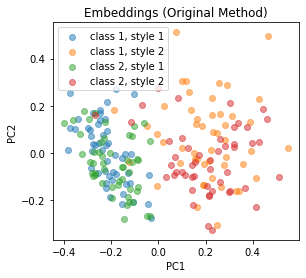

In [18]:
plt.scatter(emb_pca[0:50, 0], emb_pca[0:50, 1], alpha=0.5, label="class 1, style 1")
plt.scatter(emb_pca[50:100, 0], emb_pca[50:100, 1], alpha=0.5, label="class 1, style 2")
plt.scatter(emb_pca[100:150, 0], emb_pca[100:150, 1], alpha=0.5, label="class 2, style 1")
plt.scatter(emb_pca[150:200, 0], emb_pca[150:200, 1], alpha=0.5, label="class 2, style 2")
plt.gca().set(
    aspect="equal",
    title="Embeddings (Original Method)",
    xlabel="PC1",
    ylabel="PC2",
)
plt.legend()
plt.show()

## Our Model
Create embeddings of all images using the model from the our approach.

In [19]:
experiment_id = "dustin_lr_5e5"
our_model = load_best_model(experiment_id, OurPretextNetwork(backbone="resnet18"))

embeddings = get_embeddings(images1_style1 + images1_style2 + images2_style1 + images2_style2, our_model)
embeddings.shape

(200, 1000)

Apply PCA with 2 principal components to all embeddings.

In [20]:
pca = PCA(n_components=2)
emb_pca = pca.fit_transform(embeddings)
emb_pca.shape

(200, 2)

Visualize results

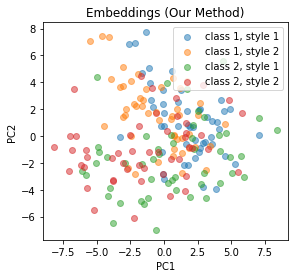

In [21]:
plt.scatter(emb_pca[0:50, 0], emb_pca[0:50, 1], alpha=0.5, label="class 1, style 1")
plt.scatter(emb_pca[50:100, 0], emb_pca[50:100, 1], alpha=0.5, label="class 1, style 2")
plt.scatter(emb_pca[100:150, 0], emb_pca[100:150, 1], alpha=0.5, label="class 2, style 1")
plt.scatter(emb_pca[150:200, 0], emb_pca[150:200, 1], alpha=0.5, label="class 2, style 2")
plt.gca().set(
    aspect="equal",
    title="Embeddings (Our Method)",
    xlabel="PC1",
    ylabel="PC2",
)
plt.legend()
plt.show()